---
title: "Bayesian Approach to A/B Testing"
author: Daniel Redel
date: "2024-05-10"
categories: [Bayesian Statistics, Causal Inference, A/B Testing, Python]
image: "cover_bayes.png"
format:
  html:
    toc: true
    code-fold: false
    html-math-method: katex
jupyter: python3
---

Bayesian A/B testing Analysis using Python.

As data scientists, we are frequently confronted with questions like: **“Does $X$ affects $Y$?”** Here, $Y$ is the outcome that we care about, while $X$ could be a new feature, product, policy or experience. How do we go about answering such *causal* questions? For online platforms, the answer **lies in experimentation**. 

By randomly assigning some kind of treatment (new interface design, new product, etc.) to a subset of users (Group A) and comparing their behavior or outcomes (such as revenue, visits, clicks, etc.) to those who did not receive the treatment (Group B), we can effectively isolate the causal impact of the change. This is at the core of **A/B testing** (also known as Randomized Control Trials), which is considered the workhorse method of experimentation for platforms like [Spotify](https://confidence.spotify.com/blog/experiment-like-spotify), [Uber](https://www.uber.com/en-NL/blog/xp/), [Netflix](https://netflixtechblog.com/what-is-an-a-b-test-b08cc1b57962), an more.

In my previous [article](https://dannyredel.github.io/posts/ab_testing1/1_ab_testing.html), we learned the basics of A/B testing using **Python**, employing traditional traditional methods. However, one distinguishing feature of platforms like Spotify is their **execution of thousands of simultaneous tests**. With so many experiments available, is there a way to leverage information from previous tests and improve the inferences we make?

In this article, I aim to address this question by introducing the **Bayesian approach** to A/B testing. The Bayesian framework proves to be highly suitable for this task as it inherently facilitates the **integration of prior knowledge with new data**, enabling more robust conclusions. Let's see how!

# 1. Case Study: E-beer Catalog Campaign

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import bernoulli, expon

sns.set_palette("viridis", 3)

import warnings
warnings.filterwarnings("ignore")

As as study case, consider **E-Beer**, a fictional online beer retailer that serves approximately 50,000 customers and operates on a swift delivery model where customers select their favorite brand, make a purchase, and receive their order within an hour. In an effort to enhance sales, E-Beer devised a **catalog campaign** to distribute to its customer base. Each catalog included a flyer to reinforce awareness of the services offered and a key ring bearing the company's name and website. 

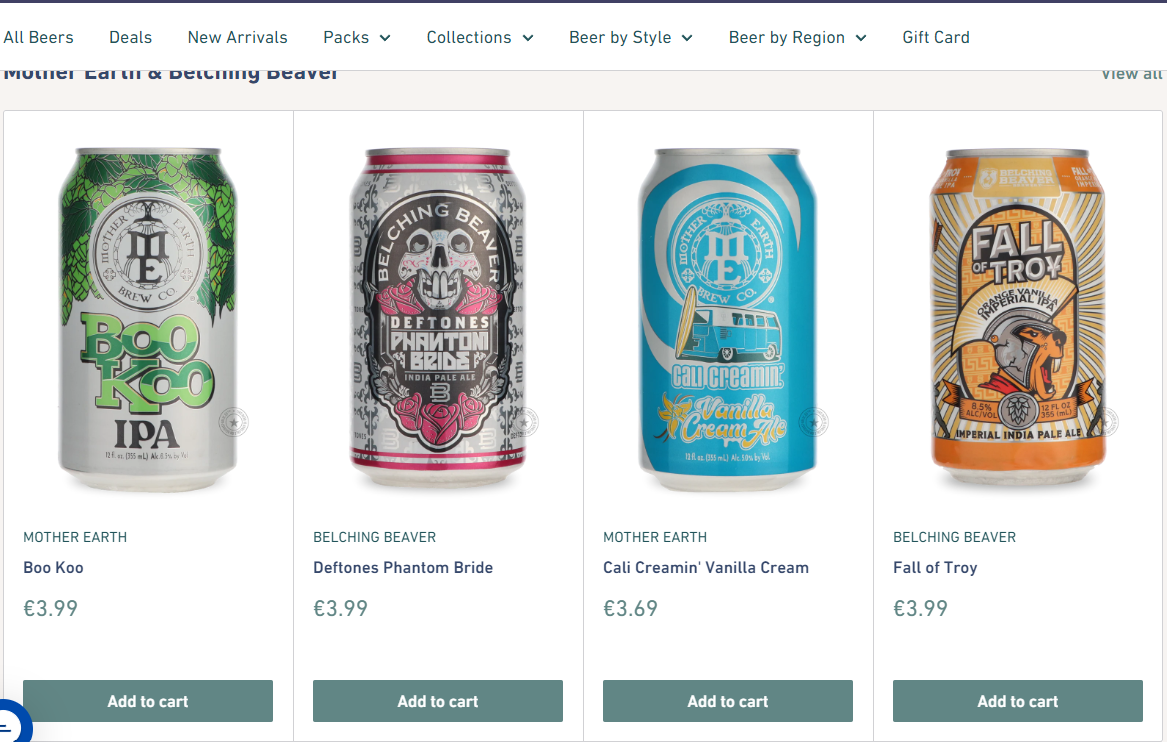

To evaluate the efficacy of the email campaign, an A/B test was conducted wherein users were randomly assigned to a treated group versus a control group that did not receive any catalog. Therefore, the design of the test enables us to address our main questions:

> 1. Does the catalog campaign lead to an increase in purchases compared to the control group (Treated vs. Control)?

But platforms are also interested in studying the number of responses the catalog mail generates. **Response rates** are one of the most common metrics for evaluating the effectiveness of email campaigns. Although response rates do not directly address causal relationships, they serve as valuable indicators of campaign performance. Here, the Bayesian approach can actually also help us to better assess the uncertainty of our response rates. Therefore, we will start the analysis by answering the following question:

> 2. What is the estimated response rate of the catalog campaign, and how confident are we in this estimate?

@tbl-raw-dataset presents a sample of the dataset containing all the information we need for our analysis:

In [5]:
#| label: tbl-raw-dataset
#| tbl-cap: Online Wine Store Dataset
#| echo: false
df = pd.read_csv('ebeer.csv')
df['respmail'] = df['respmail'].map({'1': 1, '0': 0})
df['M'] = df.apply(lambda row: row['M'] + 3.5 if row['mailing'] == 1 else row['M'], axis=1)

df.head()

,acctnum,gender,R,F,M,firstpur,age_class,single,student,mailing,respmail
0,10001,1,30,10,39.2,50,3,1,1,1,0.0
1,10005,0,16,1,152.5,16,0,0,1,1,0.0
2,10010,0,12,1,126.5,12,0,1,0,1,0.0
3,10011,0,6,2,150.5,8,0,1,1,1,0.0
4,10014,1,6,3,99.5,18,0,0,1,1,1.0


# 2. Binary Case: Response Rates

> **What is the estimated response rate of the catalog campaign, and how confident are we in this estimate?**

## 2.1. Classical Approaches: Normal Distribution vs Nonparametric Bootstrap

We want to know the uncertainty of the response rates `p`. One standard way to measure uncertainty of the possible values of the response rate is the classical framework of inference, which is to assume that `p` comes from a **normal distribution**.

We start by calculating the mean and standard deviation. Then, we'll use those parameters to plot confidence intervals (CI) and get a sense of the lay of the land: 


$$
\text{CI}_{\text{lower}} = \bar{x} - 1.96 \times \frac{\text{SE}_{\bar{x}}}{\sqrt{n}}
$$


It's classic statistical inference!

In [17]:
# Calculate the mean
xbar = df['respmail'].mean()
print("Sample Response Rate:", xbar.round(3))

# Calculate the standard error of the mean (SE)
xbse = np.sqrt(df['respmail'].var() / len(df))

# Calculate the confidence interval
ci_lower = xbar - 1.96 * xbse
ci_upper = xbar + 1.96 * xbse

print("95% Confidence Interval:")
print("Lower bound:", ci_lower.round(3))
print("Upper bound:", ci_upper.round(3))

Sample Response Rate: 0.124
95% Confidence Interval:
Lower bound: 0.118
Upper bound: 0.131


Our estimated response rate for the catalog campaign falls within a confidence interval ranging from 11.8% to 13.1% with 95% confidence. This means that, assuming normality, we're pretty confident that the true response rate lies somewhere in this range. Now, let's visualize these bounds:

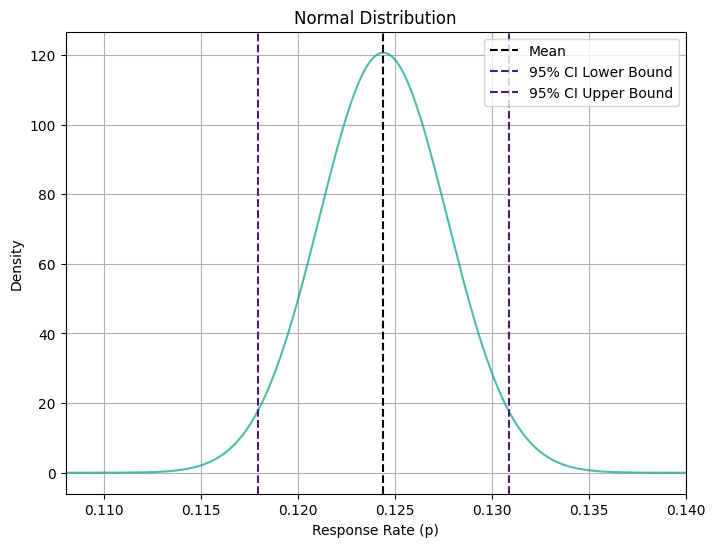

In [19]:
#| code-fold: true

# Generate xx values
xx = np.linspace(df['respmail'].min(), df['respmail'].max(), 10000)

# Calculate normal density
norm_density = pd.DataFrame({'xx': xx, 'm': np.exp(-(xx - xbar) ** 2 / (2 * xbse ** 2)) / (xbse * np.sqrt(2 * np.pi))})

# Plot using Seaborn with confidence interval
plt.figure(figsize=(8, 6))
sns.lineplot(data=norm_density, x='xx', y='m', color="#00A087B2")
plt.axvline(xbar, color="black", linestyle="--", label="Mean")
plt.axvline(ci_lower, color="#481f70", linestyle="--", label="95% CI Lower Bound")
plt.axvline(ci_upper, color="#481f70", linestyle="--", label="95% CI Upper Bound")
plt.xlim(0.108, 0.14)  # Limit x-axis range
plt.xlabel("Response Rate (p)")
plt.ylabel("Density")
plt.title("Normal Distribution")
plt.legend()
plt.grid(True)
plt.show()

If we don't want to make any distributional assumptions, we can give the **nonparametric bootstrap method** a shot. This approach allows us to leverage bootstrap sampling techniques for robust estimates of response rates. Here is the code to do **re-sampling with replacement**:

In [20]:
# Define the number of bootstrap samples
B = 10000

# Define a function to calculate response rate
def calculate_response_rate(data):
    return data.mean()

# Initialize an array to store bootstrap sample response rates
bootstrap_response_rates = np.zeros(B)

# Generate bootstrap samples and calculate response rates
for i in range(B):
    bootstrap_sample = df['respmail'].sample(frac=1, replace=True)  # Sampling with replacement
    bootstrap_response_rates[i] = calculate_response_rate(bootstrap_sample)

# Calculate mean and standard error of bootstrap response rates
bootstrap_mean = bootstrap_response_rates.mean()

# Calculate 95% confidence interval
confidence_interval = np.percentile(bootstrap_response_rates, [2.5, 97.5])
print("Bootstrap Mean:", bootstrap_mean.round(3))
print("95% Confidence Interval:", confidence_interval.round(3))

Bootstrap Mean: 0.124
95% Confidence Interval: [0.115 0.134]


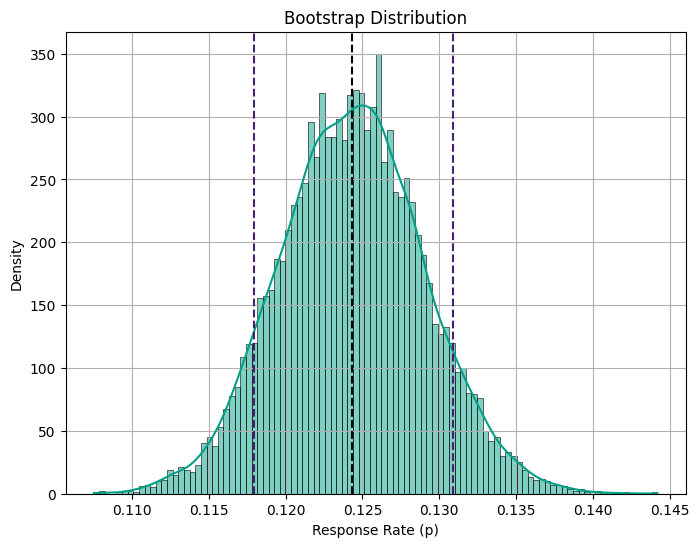

In [21]:
#| code-fold: true

# Plot using Seaborn
plt.figure(figsize=(8, 6))
sns.histplot(bootstrap_response_rates, bins=100, kde=True, color="#00A087B2", edgecolor="black", fill=True)
plt.axvline(np.mean(bootstrap_response_rates), color="black", linestyle="--", linewidth=1.5)
plt.axvline(ci_lower, color="#481f70", linestyle="--", label="95% CI Lower Bound")
plt.axvline(ci_upper, color="#481f70", linestyle="--", label="95% CI Upper Bound")
plt.xlabel("Response Rate (p)")
plt.ylabel("Density")
plt.title("Bootstrap Distribution")
plt.grid(True)
plt.show()

Upon running the resampling, we obtain a 95% confidence interval of [0.115, 0.134]. Interestingly, we notice that the uncertainty level is slightly higher in the nonparametric case (more uncertainty). This is a common trade-off when opting for fewer assumptions in our analysis.

## 2.3. Bayesian Approach

So far, everything has been very standard. But let's consider this: what if our catalog campaign isn't the only experiment we've conducted to boost our browser (and ultimately ad revenue)? Among the thousands of experiments we've run in the past, this campaign is just one idea in the mix. Can we efficiently leverage this wealth of additional information?

This is how Bayesian statistics offers a powerful advantage over the frequentist approach: the seamless integration of **additional information** into our model. The idea directly follows from the main results behind all Bayesian statistics: [**Bayes Theorem**](https://en.wikipedia.org/wiki/Bayes%27_theorem). By inverting the inference problem, Bayes' Theorem allows us to transition from the probability of the model given the data to **the probability of the data given the model**:

$$
\underbrace{ \Pr \big( \text{model} \ \big| \ \text{data} \big) }_{\text{posterior}} = \underbrace{ \Pr(\text{model}) }_{\text{prior}} \ \underbrace{ \frac{ \Pr \big( \text{data} \ \big| \ \text{model} \big) }{ \Pr(\text{data}) } }_{\text{likelihood}}
$$

We can split the right-hand side of Bayes Theorem (or Rule) into two components: the **prior** and the **likelihood**. The likelihood is the information about the model that comes from the data, the prior instead is any additional information about the model.

### Priors

As the name suggests, **priors** contain information that was available even before looking at the data. This leads to one of the most relevant questions in Bayesian statistics: **How do you choose a prior?** In practice, there are several considerations to keep in mind:

- **Beta Distribution Assumption**: Under the Bayesian framework, we assume that the true conversion rates follow a Beta distribution. This particular distribution is chosen for its flexibility and ability to capture uncertainty.
- **Uninformative or Weakly Informative Priors**: these priors are characterized by setting low values for alpha and beta. For example, alpha = 1, beta = 1 leads to a uniform distribution as a prior. If we were considering one distribution in isolation, setting this prior is a statement that **we don't know anything about the value of the parameter**, nor our confidence around it. 
- **Strong Priors**: Conversely, strong priors are characterized by high values for alpha and beta, implying that the relative uplift distribution is thin, i.e. our prior belief is that the variants are not very different from each other.

Going back to our emailing campaign, let's assume our response rate `p` comes from a **beta distribution**. The mean of the beta distribution is:

$$
\text{E}[p|a,b] = \frac{a}{a+b}
$$

Drawing insights from past experiments, we've observed that `p` tends to hover around 12.3%. To reflect this knowledge, we set the parameters $a$ and $b$ of the beta distribution accordingly: $a = 9$ and $b = 64$.

In [10]:
prior_a = 9
prior_b = 64

# Mean
p_hat = prior_a / (prior_a + prior_b)
print(round(p_hat,3))

0.123


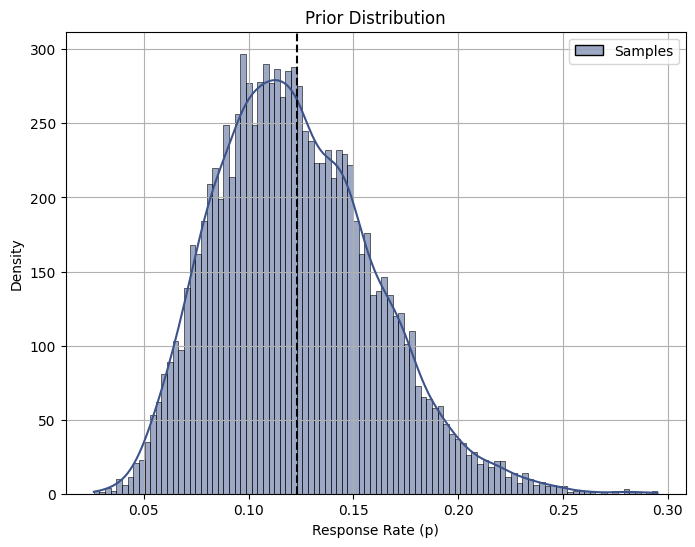

In [11]:
#| code-fold: true

# Create DataFrame with samples
B = 10000  # number draws from distribution
samples = np.random.beta(prior_a, prior_b, size=B)
beta_df = pd.DataFrame({'Samples': samples})

# Plot using Seaborn
plt.figure(figsize=(8, 6))
sns.histplot(beta_df, bins=100, kde=True, color="#00A087B2", edgecolor="black", fill=True)
plt.axvline(p_hat, color="black", linestyle="--", linewidth=1.5)
plt.xlabel("Response Rate (p)")
plt.ylabel("Density")
plt.title("Prior Distribution")
plt.grid(True)
plt.show()

It's worth noting that the beta distribution exhibits a slight leftward skewness, suggesting that lower response rates may be more likely than higher response rates, which is a common pattern in scenarios where there are factors such as limited customer engagement or market saturation.

### Posterior

Bayes rule tells you how you should update your beliefs after you see some data:

$$ \textrm{posterior} \propto \textrm{likelihood} \times \textrm{prior} $$

Now, we already assume some prior and now we run the experiment and we see our data results. With this, we can update our prior belief by calculating the posterior. Our observed experiment had the following characteristics:

In [12]:
#| code-fold: true

print('Number Emails sent:', df.mailing.sum() )
print('Number of responses:', df[df['mailing'] == 1].respmail.sum() )
print('Response Rate', df[df['mailing'] == 1].respmail.mean().round(4)*100 )

Number Emails sent: 4952
Number of responses: 616.0
Response Rate 12.44


If we observe $s$ responses in $n$ observations, we can update our data by using the following equations:

$$
f(p)=p^{a+x-1}(1-p)^{b+n-s-1}\approx\text{beta}[a+s,b+n-s]
$$ 

In [13]:
# Define parameters
B = 10000
n = df.mailing.sum()                       # number in test sample
s = df[df['mailing'] == 1].respmail.sum()  # number of responses

post_a = prior_a + s
post_b = prior_b + n - s

In [14]:
from scipy.stats import beta

# Calculate mean posterior response rate
p_hat1 = post_a / (post_a + post_b)

# Print mean response rate
print("The Posterior Mean response rate is", round(p_hat1, 3))

# Calculate prior and posterior confidence intervals
prior_ci = beta.ppf([0.025, 0.975], prior_a, prior_b)
posterior_ci = beta.ppf([0.025, 0.975], post_a, post_b)

# Print confidence intervals
print("Prior Response Rate 95% CI:", prior_ci.round(3))
print("Posterior Response Rate 95% CI:", posterior_ci.round(3))

The Posterior Mean response rate is 0.124
Prior Response Rate 95% CI: [0.059 0.207]
Posterior Response Rate 95% CI: [0.115 0.134]


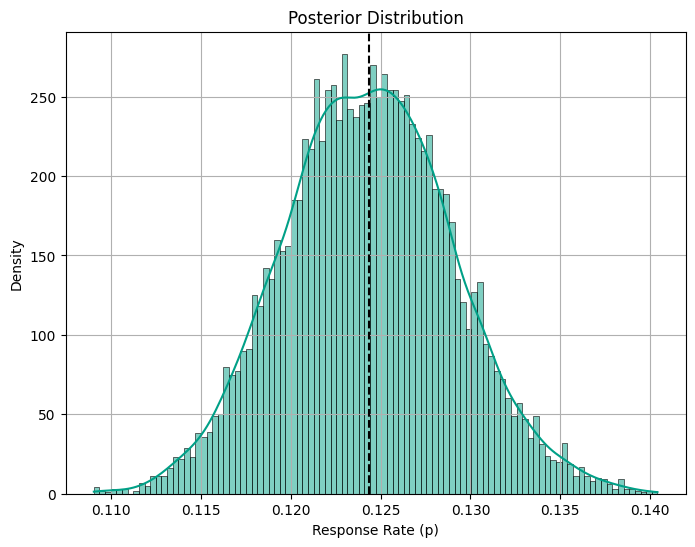

In [15]:
#| code-fold: true

# Generate posterior density samples
posterior_density = np.random.beta(a=post_a, b=post_b, size=B)

# Plot using Seaborn
plt.figure(figsize=(8, 6))
sns.histplot(posterior_density, bins=100, kde=True, color="#00A087B2", edgecolor="black", fill=True)
plt.axvline(p_hat1, color="black", linestyle="--", linewidth=1.5)
plt.xlabel("Response Rate (p)")
plt.ylabel("Density")
plt.title("Posterior Distribution")
plt.grid(True)
plt.show()

The Bayesian approach provides a posterior mean response rate of 0.124, along with a 95% confidence interval (CI) for the response rate ranging from 0.115 to 0.134. In this case, the standard approaches reported similar confidence intervals.

### Breakeven Point

Platforms often seek to determine whether the response rate from a campaign surpasses a minimum threshold necessary to cover the costs incurred. This minimum threshold is known as the **breakeven point**.  For instance, let's consider a scenario where the cost per mailing ($c$) amounts to \$5.75, while the profits generated per response ($m$) stand at \$50.

We can calculate the probability that the posterior is *above the breakeven point*, which in this case is: $$ p >\frac{c}{\pi} \equiv \frac{5.75}{50} = 0.115 $$

So that we are interested in: $$ \Pr(p<0.115) $$ We estimate the probability by drawing from a beta distribution with above parameters.

In [15]:
c = 5.75   # cost per mailing
m = 50   # profit if respond

# Calculate breakeven point
brk = c / m
print("Breakeven point:", brk)

Breakeven point: 0.115


In [16]:
# Set random seed
np.random.seed(19312)

# Generate random deviates
post_draws = np.random.beta(post_a, post_b, size=B)

# Calculate probability of passing breakeven point
prob_passing = np.sum(post_draws < brk) / B

# Print probability
print("The Probability that the response rate is below the breakeven point is", round(prob_passing, 3))

The Probability that the response rate is below the breakeven point is 0.02


With only a 2% probability of the response rate falling below the breakeven point, the results indicate a favorable outcome, indicating that the campaign's effectiveness in generating responses is promising in relation to its profitability. 

# 3. Continuous Case: A/B Testing 

We are now ready to tackle our primary question: 

> _Does the catalog campaign effectively drive purchases compared to the control group (Treated vs. Control)?_ 

Before delving into the A/B testing analysis, it is good practice to build a **balance table** to check the comparability of our treatment and control groups across key covariates (see my previous post [here](https://dannyredel.github.io/posts/ab_testing1/1_ab_testing.html)):

In [18]:
#| code-fold: true

import numpy as np
import pandas as pd

def smd(feature, treatment):
    """Calculate the standard mean difference (SMD) of a feature between the
    treatment and control groups.

    Args:
        feature (pandas.Series): a column of a feature to calculate SMD for
        treatment (pandas.Series): a column that indicate whether a row is in
                                   the treatment group or not

    Returns:
        (float): The SMD of the feature
    """
    t = feature[treatment == 1]
    c = feature[treatment == 0]
    return (t.mean() - c.mean()) / np.sqrt(0.5 * (t.var() + c.var()))



def create_table_one(data, treatment_col, features):
    """Report balance in input features between the treatment and control groups.

    Args:
        data (pandas.DataFrame): total or matched sample data
        treatment_col (str): the column name for the treatment
        features (list of str): the column names of features

    Returns:
        (pandas.DataFrame): A table with the means and standard deviations in
            the treatment and control groups, and the SMD between two groups
            for the features.
    """
    t1 = pd.pivot_table(
        data[features + [treatment_col]],
        columns=treatment_col,
        aggfunc=[lambda x: "{:.2f} ({:.2f})".format(x.mean(), x.std())],
    )
    t1.columns = t1.columns.droplevel(level=0)
    t1["SMD"] = data[features].apply(lambda x: smd(x, data[treatment_col])).round(4)

    n_row = pd.pivot_table(
        data[[features[0], treatment_col]], columns=treatment_col, aggfunc=["count"]
    )
    n_row.columns = n_row.columns.droplevel(level=0)
    n_row["SMD"] = ""
    n_row.index = ["n"]

    t1 = pd.concat([n_row, t1], axis=0)
    t1.columns.name = ""
    t1.columns = ["Control", "Treatment", "SMD"]
    t1.index.name = "Variable"

    return t1

In [34]:
#| label: tbl-balancetable
#| tbl-cap: Balance Table
my_cov = ['gender', 'firstpur', 'age_class', 'single', 'student']
create_table_one(df, 'mailing', my_cov)

,Control,Treatment,SMD
Variable,,,
n,5012,4952,
age_class,0.85 (1.10),0.85 (1.10),-0.0031
firstpur,26.33 (18.15),26.62 (18.28),0.0156
gender,0.30 (0.46),0.30 (0.46),0.0096
single,0.31 (0.46),0.30 (0.46),-0.0064
student,0.53 (0.50),0.53 (0.50),-0.0033


From @tbl-balancetable we observe a stable distribution across covariates, indicating successful randomization. All good so far.

## 3.1. Classical Approach: Linear Regression

As explored in my [previous post on A/B Testing](https://dannyredel.github.io/posts/ab_testing1/1_ab_testing.html), we can quantify the impact of our catalog campaign using a standard linear regression model. In this case, I would like to know the impact of the campaign on **Purchase Value $M$** of customers on the E-beer store during a given period:

$$
Y_{i} = \alpha + \beta D_i + \varepsilon_i
$$

where $D_i$ is the treatment indicator (equal to 1 for treated units and 0 for control units), $\alpha$ is the intercept term and $\beta$ is our coefficient of interest representing the **Average Treatment Effect**.

In [52]:
#| label: tbl-reg1
#| tbl-cap: A/B Regression Results I
import statsmodels.formula.api as smf

smf.ols('M ~ mailing', data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,92.2839,1.066,86.589,0.000,90.195,94.373
mailing,2.9149,1.512,1.928,0.054,-0.049,5.878


According to @tbl-reg1, while the coefficient associated with the treatment variable (`mailing`) suggests a positive impact of the catalog campaign, these effects do not achieve statistical significance. The 95% Confidence Intervals for the coefficient range from -0.049 to 5.878, indicating substantial uncertainty surrounding the estimated treatment effect. 

**Can we do better?** Let's leverage information from previous tests with the Bayesian framework.

## 3.2. Bayesian Approach: Uninformative Prior

### Prior

When choosing a prior, one analytically appealing restriction is to have a prior distribution such that the posterior belongs to the same family. For example, in the case of a continuous dependent variable ($M$), I can assume my treatment effect is **normally distributed** and I would like it to be normally distributed also after incorporating the information contained in the data.

Now, before observing any data, I knew nothing about how much people might spend on beers online. They might spend 2 euros or they might stay for 200 euros. Formally, I can describe my **weakly informative** prior beliefs with a *prior distribution*: 

$$\textrm{mean Purchase-Value by group} \sim N(0, 100^2)$$


Here is how the distribution looks like:

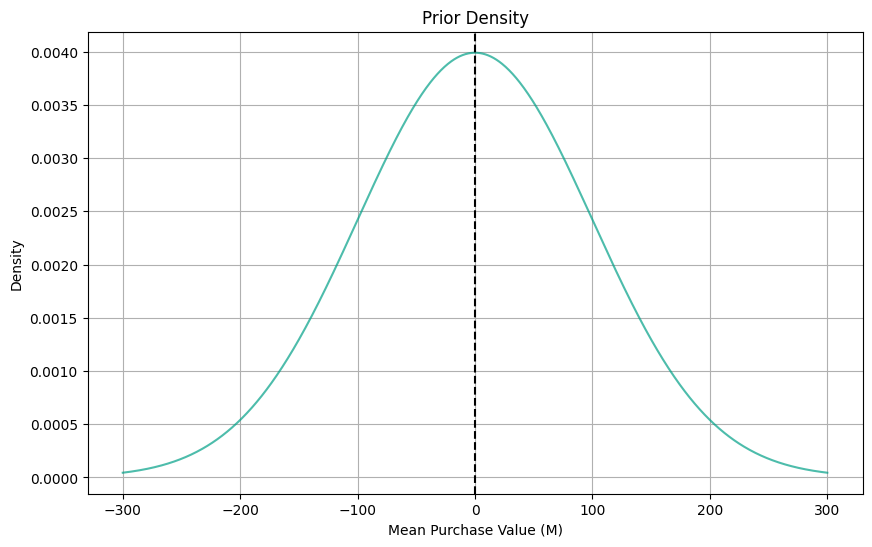

In [22]:
#| code-fold: true

# Prior parameters
prior_mean = 0
prior_sd = 100

# Generate x-values for plotting
xx = np.linspace(-300, 300, num=1000)

# Calculate prior density
prior_density = (1 / (prior_sd * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((xx - prior_mean) / prior_sd) ** 2)

# Plot prior density using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(x=xx, y=prior_density, color='#00A087B2')
plt.axvline(prior_mean, color="black", linestyle="--", linewidth=1.5)
plt.title('Prior Density')
plt.xlabel('Mean Purchase Value (M)')
plt.ylabel('Density')
plt.grid(True)
plt.show()

### Posterior

Then Bayes rule tells us that the **posterior distribution** for mean purchase-value for each group should be:

$$
\textrm{mean time-on-site (m)} \sim \mathcal{N}\left(\mu, \sigma^2\right) 
$$where

$$
 \sigma = \left(\frac{1}{\sigma_{0}^2} + \frac{n}{s^2}\right)^{-1}
$$

and

$$
\mu = \sigma^2 \left(\frac{\mu_0}{\sigma_{0}^2} + \frac{n \bar{y}}{s^2}\right)
$$

In [79]:
# Posterior parameters
n_A = df.shape[0] - df.mailing.sum()
n_B = df.mailing.sum()
s = df.M.std()  # Standard deviation of data (approx==2)
ybar_A = df[df['mailing'] == 0].M.mean()
ybar_B = df[df['mailing'] == 1].M.mean()

# Posterior standard deviation
posterior_sd_A = (1 / (prior_sd ** 2) + n_A / (s ** 2)) ** (-0.5)
posterior_sd_B = (1 / (prior_sd ** 2) + n_B / (s ** 2)) ** (-0.5)

# Posterior mean
posterior_mean_A = posterior_sd_A ** 2 * ((prior_mean / (prior_sd ** 2)) + (n_A * ybar_A / (s ** 2)))
posterior_mean_B = posterior_sd_B ** 2 * ((prior_mean / (prior_sd ** 2)) + (n_B * ybar_B / (s ** 2)))


print("Posterior Mean Estimate for Group A:", posterior_mean_A.round(1))
print("Posterior Mean Estimate for Group B:", posterior_mean_B.round(1))

Posterior Mean Estimate for Group A: 92.3
Posterior Mean Estimate for Group B: 95.2


We can plot each posterior distribution to compare:

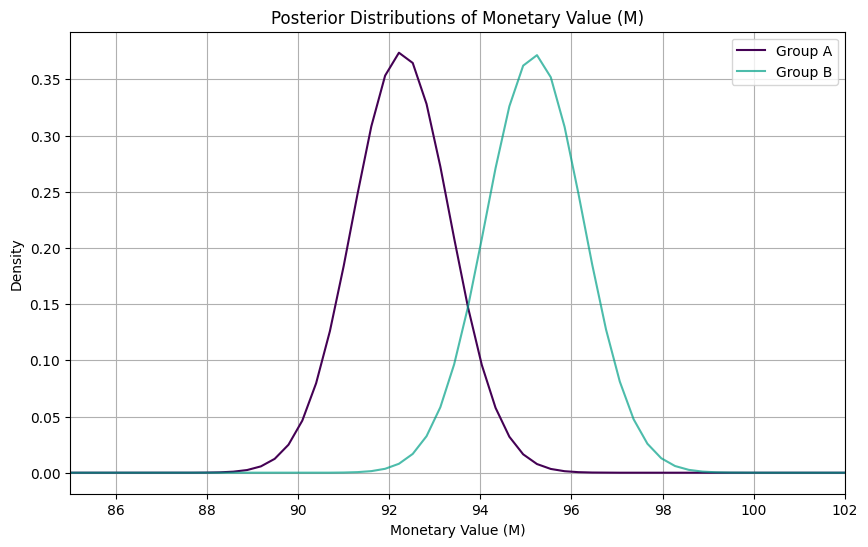

In [80]:
#| code-fold: true

# Plot posterior distributions
xx = np.linspace(min(df['M']), max(df['M']), 1000)
posterior_distribution_A = (1 / (posterior_sd_A * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((xx - posterior_mean_A) / posterior_sd_A) ** 2)
posterior_distribution_B = (1 / (posterior_sd_B * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((xx - posterior_mean_B) / posterior_sd_B) ** 2)

plt.figure(figsize=(10, 6))
sns.lineplot(x=xx, y=posterior_distribution_A, label='Group A', color='#440154')
sns.lineplot(x=xx, y=posterior_distribution_B, label='Group B', color='#00A087B2')
plt.xlim(85, 102)  # Limit x-axis range

plt.title('Posterior Distributions of Monetary Value (M)')
plt.xlabel('Monetary Value (M)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

Excellent! With the Bayesian approach, we've estimated the posterior mean purchase value for Group A to be $92.3 and for Group B to be $95.2. Once we have these distribution for the difference in the mean, we can compute the probability that the mean of B is greater than the mean of A and Confidence Intervals:

In [81]:
from scipy.stats import norm

# Calculate the difference in means
post_mean_diff = posterior_mean_B - posterior_mean_A
print("Posterior Average Treatment Effect:", post_mean_diff.round(3))

# Calculate the standard deviation of the difference
post_sd_diff = np.sqrt(posterior_sd_B ** 2 + posterior_sd_A ** 2)

# Compute the probability
prob = 1 - norm.cdf(0, loc=post_mean_diff, scale=post_sd_diff)
print("Probability that mean of B is greater than mean of A:", prob.round(3))

# Calculate the 95% confidence interval
ci_lower = norm.ppf(0.025, loc=post_mean_diff, scale=post_sd_diff)
ci_upper = norm.ppf(0.975, loc=post_mean_diff, scale=post_sd_diff)
print("95% Confidence Interval for the Difference in Means:", (ci_lower.round(3), ci_upper.round(3)))

Posterior Average Treatment Effect: 2.914
Probability that mean of B is greater than mean of A: 0.973
95% Confidence Interval for the Difference in Means: (-0.049, 5.878)


On average, the treatment (catalog campaign) leads to an increase in purchase value by approximately $2.914 compared to the control group. The confidence interval for the difference in means ranges from -0.049 to 5.878. Since this interval includes zero, we **cannot** conclude with 95% confidence that there is a statistically significant difference in purchase values between the treated and control groups. 

This suggests that the catalog campaign may not have a significant impact on purchase behavior compared to the control group, based on the observed data.

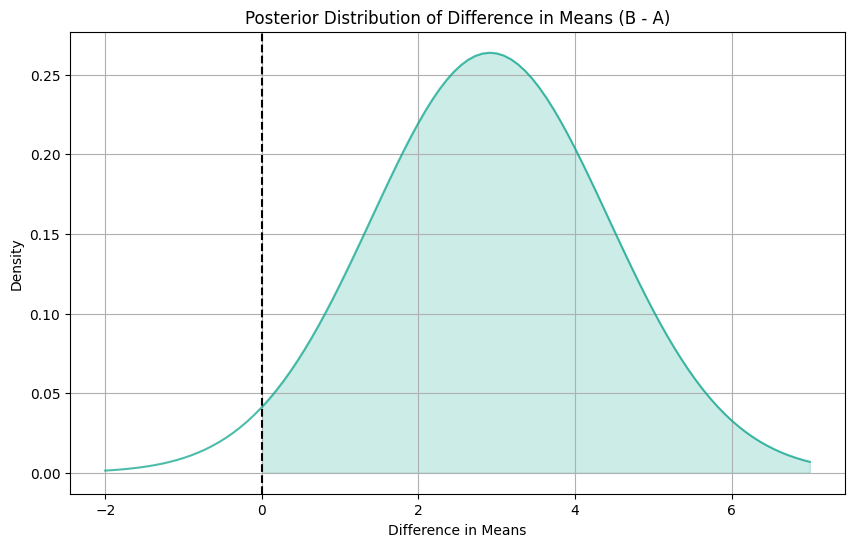

In [82]:
#| code-fold: true

# Generate x-values for plotting
xx_diff = np.linspace(-2, 7, num=100)

# Calculate the posterior density of the difference
post_density_diff = norm.pdf(xx_diff, loc=post_mean_diff, scale=post_sd_diff)

# Plot the posterior distribution of the difference using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(x=xx_diff, y=post_density_diff, color='#00A087B2')
plt.title('Posterior Distribution of Difference in Means (B - A)')
plt.axvline(x=0, color='black', linestyle='--', label='Zero difference')
plt.xlabel('Difference in Means')
plt.ylabel('Density')
plt.grid(True)

# Shade the area to the right of 0 to calculate the probability
plt.fill_between(xx_diff, post_density_diff, where=(xx_diff >= 0), color='#00A087B2', alpha=0.2)

plt.show()

## 3.3. Bayesian Approach: Student-t Prior

What if we have a **more informative prior**? What if past experiments tell us that the distribution is actually more similar to a **t-student distribution**, for example?

While we've previously assumed a normal distribution for our prior, which is appropriate for continuous data with a large sample size, we can explore also the t-student distribution, which is more robust to outliers and has heavier tails compared to the normal distribution. This is a setting that happens often in the industry.

In [23]:
from scipy.stats import t

# Assuming you have a DataFrame df with columns 'mailing' and 'M'
# Filter the data for group A and group B
group_A = df[df['mailing'] == 0]['M']
group_B = df[df['mailing'] == 1]['M']

# Prior parameters for Student's t-distribution
prior_df = 1.3  # degrees of freedom
prior_loc = 0  # mean
prior_scale = 100  # scale (similar to standard deviation)

# Likelihood function (assuming a normal likelihood)
def likelihood(data, mean):
    sd = data.std()  # Standard deviation from the data
    return np.prod(1 / (sd * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((data - mean) / sd) ** 2))

# Posterior parameters for group A
posterior_mean_A = group_A.mean()
posterior_sd_A = np.sqrt(prior_scale ** 2 / (prior_scale ** 2 + (group_A.std() ** 2) / len(group_A)))

# Posterior parameters for group B
posterior_mean_B = group_B.mean()
posterior_sd_B = np.sqrt(prior_scale ** 2 / (prior_scale ** 2 + (group_B.std() ** 2) / len(group_B)))

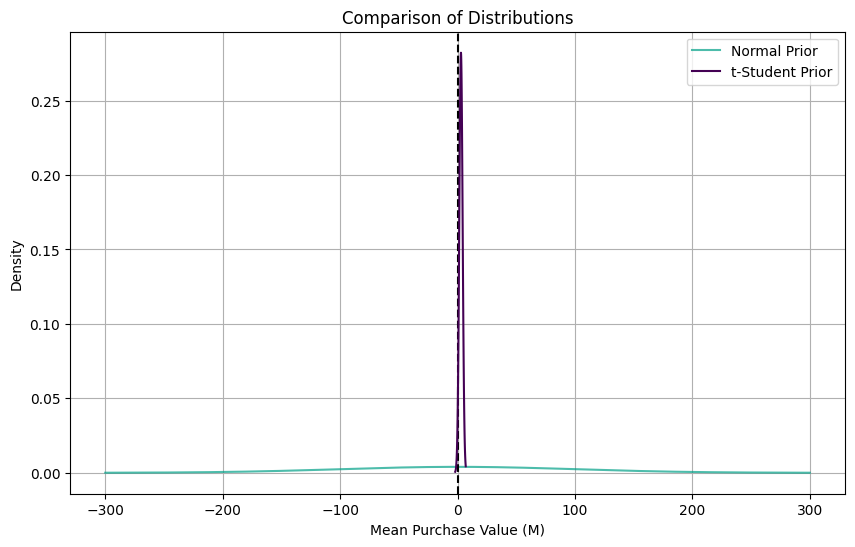

In [25]:
#| code-fold: true

from scipy.stats import norm

# Prior parameters
prior_mean = 0
prior_sd = 100

# Generate x-values for plotting
xx = np.linspace(-300, 300, num=1000)

# Calculate prior density
prior_density = (1 / (prior_sd * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((xx - prior_mean) / prior_sd) ** 2)

# Calculate the difference in means
post_mean_diff = posterior_mean_B - posterior_mean_A

# Calculate the standard deviation of the difference
post_sd_diff = np.sqrt(posterior_sd_B ** 2 + posterior_sd_A ** 2)

# Generate x-values for plotting
xx_diff = np.linspace(-2, 7, num=100)

# Calculate the posterior density of the difference using Normal prior
post_density_diff_normal = norm.pdf(xx_diff, loc=post_mean_diff, scale=post_sd_diff)

# Plot prior density and posterior distribution of the difference using Seaborn
plt.figure(figsize=(10, 6))

# Plot prior density
sns.lineplot(x=xx, y=prior_density, color='#00A087B2', label='Normal Prior ')
plt.axvline(prior_mean, color="black", linestyle="--", linewidth=1.5)

# Plot posterior distribution of the difference
sns.lineplot(x=xx_diff, y=post_density_diff_normal, color='#440154', label='t-Student Prior')

plt.title('Comparison of Distributions')
plt.xlabel('Mean Purchase Value (M)')
plt.ylabel('Density')
plt.grid(True)
plt.legend()
plt.show()

As we can see from this plot, all distributions are centered on zero, but they have very different shapes. Let's estimate our Confidence Intervals:

In [85]:
print("Posterior Average Treatment Effect:", post_mean_diff.round(3))

# Calculate the 95% confidence interval using the t-distribution
ci_lower = t.ppf(0.025, df=(len(group_A) + len(group_B)) - 2, loc=post_mean_diff, scale=post_sd_diff)
ci_upper = t.ppf(0.975, df=(len(group_A) + len(group_B)) - 2, loc=post_mean_diff, scale=post_sd_diff)
print("95% Confidence Interval for the Difference in Means:", (ci_lower.round(3), ci_upper.round(3)))

Posterior Average Treatment Effect: 2.915
95% Confidence Interval for the Difference in Means: (0.143, 5.687)


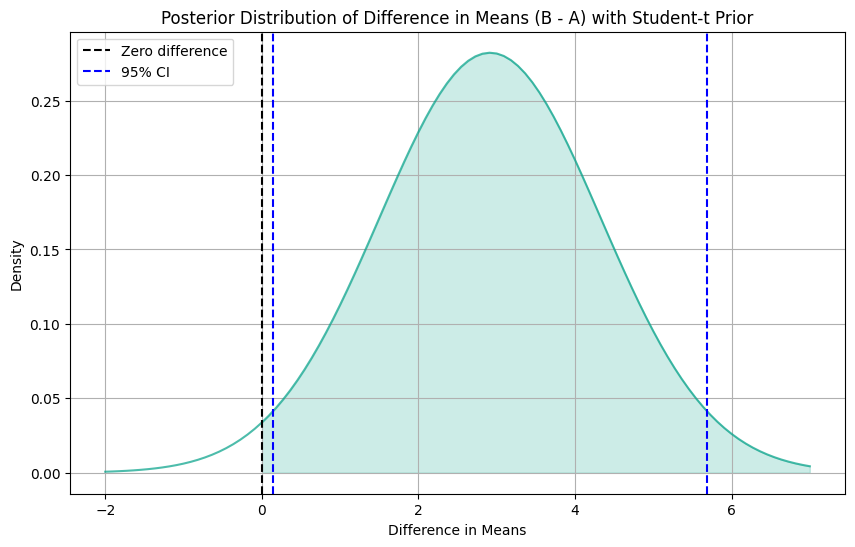

In [75]:
#| code-fold: true
from scipy.stats import t

# Generate x-values for plotting
xx_diff = np.linspace(-2, 7, num=100)

# Calculate the posterior density of the difference using Student's t-distribution
post_density_diff = t.pdf(xx_diff, df=(len(group_A) + len(group_B)) - 2, loc=post_mean_diff, scale=post_sd_diff)


# Plot the posterior distribution of the difference using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(x=xx_diff, y=post_density_diff, color='#00A087B2')
plt.title('Posterior Distribution of Difference in Means (B - A) with Student-t Prior')
plt.xlabel('Difference in Means')
plt.ylabel('Density')
plt.grid(True)

# Shade the area to the right of 0 to calculate the probability
plt.fill_between(xx_diff, post_density_diff, where=(xx_diff >= 0), color='#00A087B2', alpha=0.2)

# Add a vertical line at the point where the difference in means is zero
plt.axvline(x=0, color='black', linestyle='--', label='Zero difference')

# Add confidence interval lines
plt.axvline(x=ci_lower, color='blue', linestyle='--', label='95% CI')
plt.axvline(x=ci_upper, color='blue', linestyle='--')

plt.legend()
plt.show()

At first glance, the Posterior Average Treatment Effect (ATE) appears to be similar to our previous findings. But now, these results are statistically significant. Unlike our previous analysis, the 95% Confidence Interval for the Difference in Means now ranges from 0.143 to 5.687. The change in significance might be attributed to the adoption of a more informative prior distribution, which has provided greater precision in our estimates.

# 5. Conclusions

In this post, we've explored Bayesian Statistics to leverage information from previous A/B tests and improve the inferences of our parameters of interest. We focused our attention on how to choose appropriate priors and its influence on precision. While we touched briefly on this aspect, the choice of distribution function holds equal importance to the fine-tuning of its parameters. Indeed, the shape of the prior distribution exerts a significant influence on our inference, particularly in scenarios characterized by skewed distributions.